In [1]:
import pandas as pd

prior_order_df = pd.read_csv('./data/order_products__prior.csv')
prior_order_train_df = pd.read_csv('./data/order_products__train.csv')
order_df = pd.read_csv('./data/orders.csv')
product_df = pd.read_csv('./data/products.csv')
aisles_df = pd.read_csv('./data/aisles.csv')
department_df = pd.read_csv('./data/departments.csv')
sample_df = pd.read_csv('./data/sample_submission.csv') # 결과 도출하는 예시 파일

In [3]:
# user가 어떤 물품을 구매했는지
df = order_df.merge(prior_order_df, how='inner', on='order_id')

In [5]:
df = df.merge(product_df, how='inner', on='product_id')

In [7]:
df = df.merge(aisles_df, how='inner', on='aisle_id')
df = df.merge(department_df, how='inner', on='department_id')

In [9]:
df.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department
0,2539329,1,prior,1,2,8,NaN,196,1,0,Soda,77,7,soft drinks,beverages
1,2539329,1,prior,1,2,8,NaN,14084,2,0,Organic Unsweetened Vanilla Almond Milk,91,16,soy lactosefree,dairy eggs
2,2539329,1,prior,1,2,8,NaN,12427,3,0,Original Beef Jerky,23,19,popcorn jerky,snacks
3,2539329,1,prior,1,2,8,NaN,26088,4,0,Aged White Cheddar Popcorn,23,19,popcorn jerky,snacks
4,2539329,1,prior,1,2,8,NaN,26405,5,0,XL Pick-A-Size Paper Towel Rolls,54,17,paper goods,household


### add_to_cart_order 컬럼 분석
1. 고객들이 장바구니에 넣는 개수 확인해볼 것.

#### 특이한 케이스

- 장바구니에 넣는 순서 중 최대 145인 경우 -> 145개의 물품을 담았다는 의미로 해석됨.
- 즉, 대량 구매를 무엇을 했는지 확인
- user_id = 22906 고객으로 확인. order_id = 1564244
- 해당 고객의 

In [12]:
df['add_to_cart_order'].value_counts()

add_to_cart_order
1      3214874
2      3058126
3      2871133
4      2664106
5      2442025
        ...   
141          1
142          1
143          1
144          1
145          1
Name: count, Length: 145, dtype: int64

In [14]:
df['add_to_cart_order'].unique()

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145], dtype=int64)

In [16]:
df[df['add_to_cart_order'] == 145]

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department
3590224,1564244,22906,prior,4,2,10,30.0,23737,145,0,Organic 100% Grapefruit Juice,31,7,refrigerated,beverages


In [18]:
outlier_user_df = df[df['user_id'] == 22906]

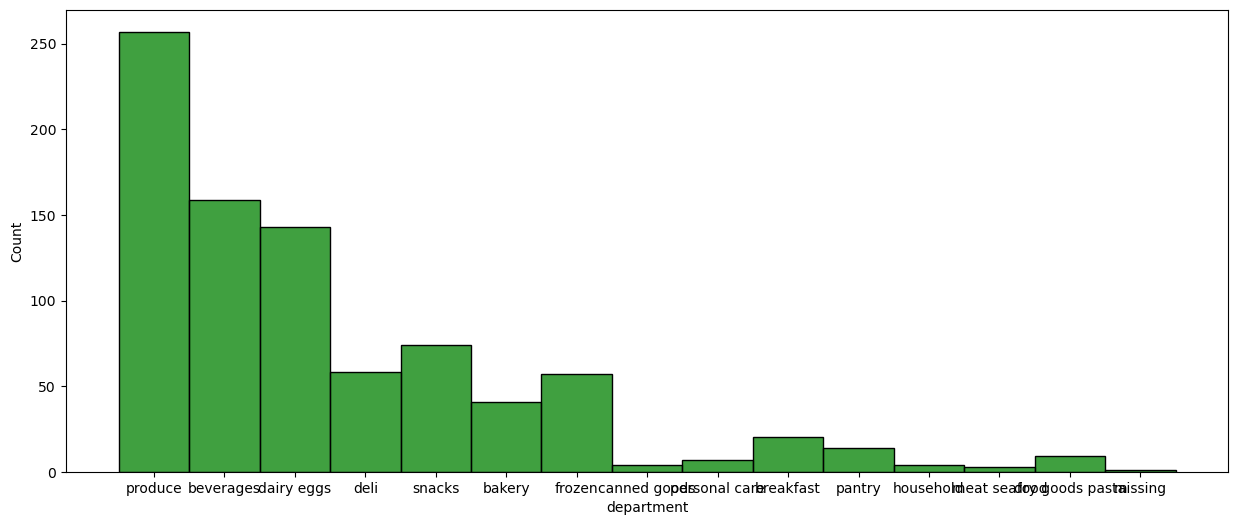

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15, 6))
sns.histplot(outlier_user_df['department'], color='green')
plt.show()

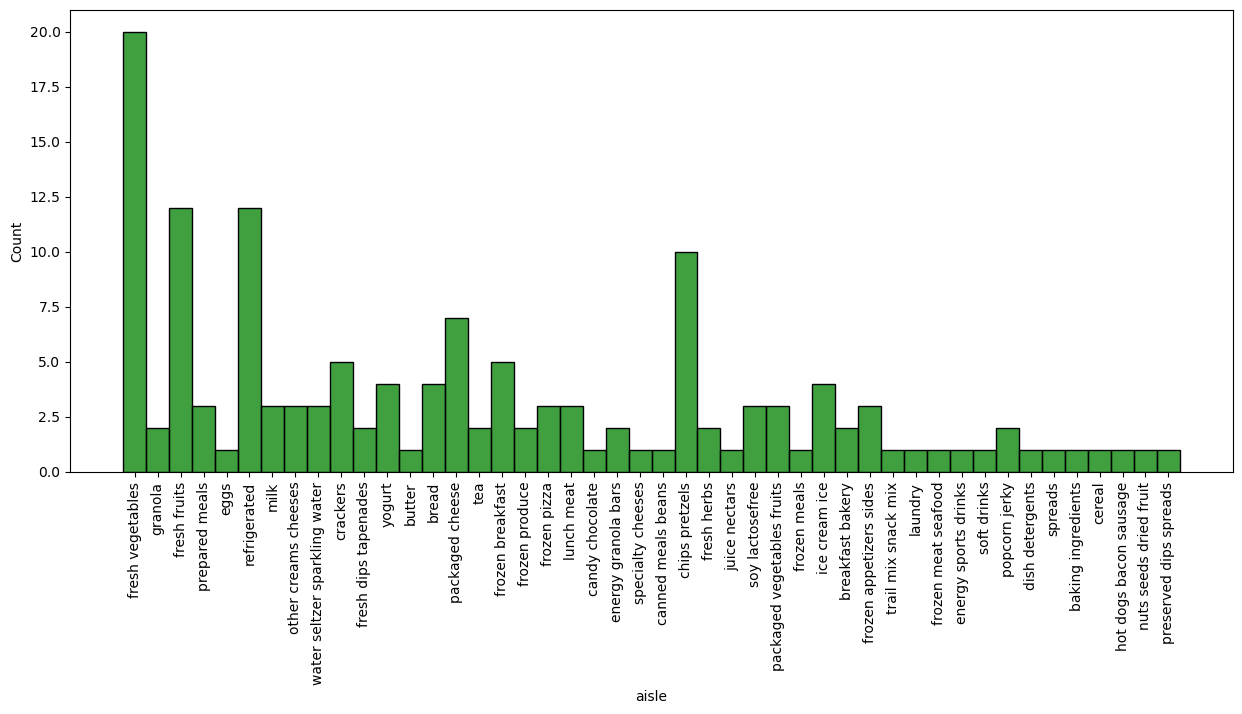

In [22]:
# 145개를 주문한 데이터에서 물품 항목
plt.figure(figsize=(15, 6))
sns.histplot(outlier_user_df[outlier_user_df['order_id'] == 1564244]['aisle'], color='green')
plt.xticks(rotation=90)
plt.show()

In [24]:
outlier_user_df['order_number'].max()

22

In [26]:
outlier_user_df['days_since_prior_order'].min()

0.0

#### user_id = 22906 고객 확인 결과
- 최근까지 구입을 하는 고객으로 확인 -> 22번 주문, 최근까지 구매한 기록 확인
- 145개 구입 기록 확인 결과 식품위주로 구매한 것을 확인
- 딱히 특이한 점은 확인 할 수 없었음.

### 주요 상품의 우선순위 분석
- 상품별로 add_to_cart_order의 평균값을 계산하여 우선순위가 높은 제품과 낮은 제품을 비교할 수 있습니다.
- 예를 들어, 평균 add_to_cart_order 값이 낮으면 우선순위가 높은 상품으로 간주할 수 있습니다.

In [30]:
avg_order = df.groupby('department')['add_to_cart_order'].mean().sort_values()

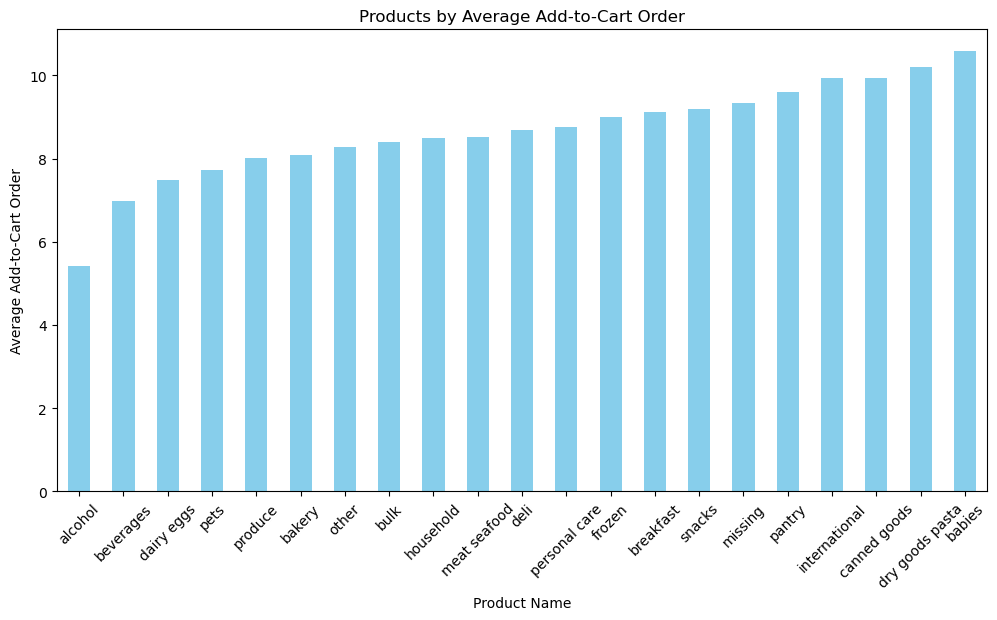

In [31]:
plt.figure(figsize=(12, 6))
avg_order.plot(kind='bar', color='skyblue')
plt.title('Products by Average Add-to-Cart Order')
plt.xlabel('Product Name')
plt.ylabel('Average Add-to-Cart Order')
plt.xticks(rotation=45)
plt.show()

- 전체를 기준으로 확인 해본 결과 produce가 높을 것이라 예상하였으나, alcohol 상품의 우선 순위가 높은 것으로 확인하였습니다.
- 하지만, 구매 개수에 따라서 결과가 달라질 수도 있을 거라 예상
- 추가적으로 요일과 시간에 따른 상품 우선 순위 확인해보기

### 2. 연관 상품 분석
- 장바구니에 담는 순서로 제품 간의 연관성을 분석할 수 있습니다. 예를 들어, 고객이 A 상품을 먼저 담고 나서 B 상품을 담는 경우가 많다면 두 상품은 연관성이 높을 수 있습니다.

### 3. 충동 구매 분석
- 마지막에 담긴 상품들은 충동 구매로 볼 수 있는 가능성이 있습니다. 고객이 구매 목록에 없던 제품을 마지막에 추가했을 경우, 프로모션이나 할인 쿠폰이 영향을 미쳤을 수 있습니다.

- 분석 방법:
- 장바구니 내에서 마지막으로 추가된 상품의 비율을 분석하고, 해당 상품의 특성을 살펴봅니다.
- 마지막으로 담긴 상품들의 카테고리를 분석해보면 충동 구매의 경향을 파악할 수 있습니다.

In [37]:
last_cart_order = df.groupby('order_id')['add_to_cart_order'].max().reset_index()

In [38]:
last_cart_order.head()

,order_id,add_to_cart_order
0,2,9
1,3,8
2,4,13
3,5,26
4,6,3


In [41]:
last_product_df = pd.merge(df, last_cart_order, on=['order_id', 'add_to_cart_order'])

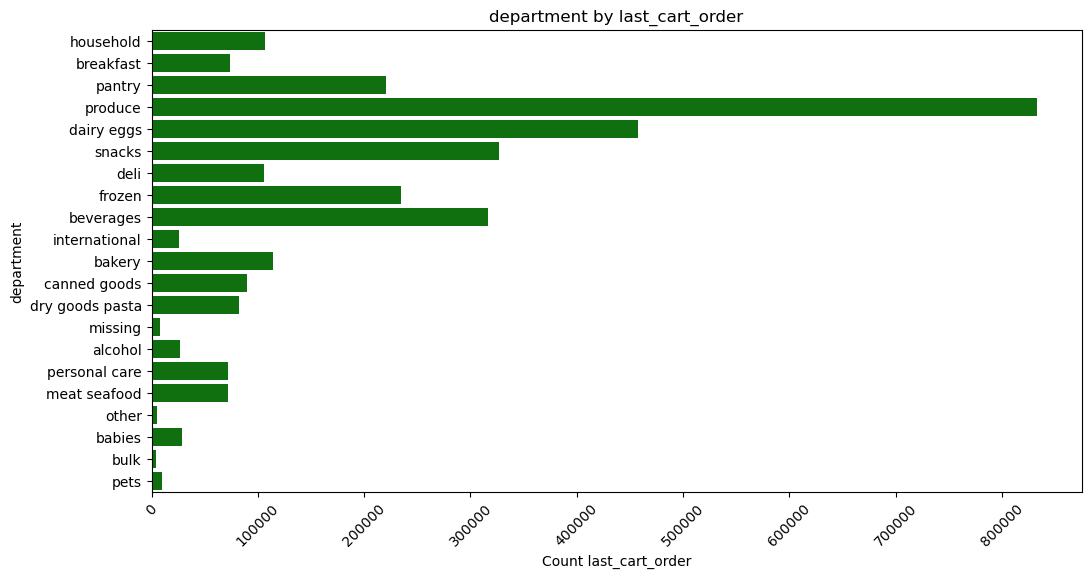

In [43]:
plt.figure(figsize=(12, 6))
sns.countplot(last_product_df['department'], color='green')
plt.title('department by last_cart_order')
plt.xlabel('Count last_cart_order')
plt.ylabel('department')
plt.xticks(rotation=45)
plt.show()

In [45]:
last_products = last_product_df[['order_id', 'product_id', 'product_name']]

In [47]:
last_products['product_name'].value_counts().head(10)

product_name
Banana                    30098
Bag of Organic Bananas    29826
Organic Strawberries      23477
Organic Baby Spinach      21733
Organic Hass Avocado      15544
Strawberries              15529
Organic Avocado           12546
Large Lemon               11883
Organic Blueberries       11347
Organic Whole Milk        11003
Name: count, dtype: int64

- 충동 구매물품이 무엇인지 확인 해본 결과 produce나 dairy eggs로 확인되었으나, 해당 제품들은 자주 구매하는 경향이 있는 것으로 분석되었었습니다.
- 그래서 마지막에 담길 상품이라해서 충동구매라 볼 수는 없을 것 같습니다.

### 30일 이후 주기로 산 구매자들 중 돌아오는 주기 평균 확인하기
- 결과 평균 20일 주기로 돌아옴 거의 10일 사이 동안은 돌아오지 않음
- 이건 당연하게도 왠만한 고개들의 주문 주기 확인 하면 거의 7일 주기이므로 계속 이용하는 구매자들로 확실하게 알아낼 수는 없었음.

In [51]:
not_30_day_df = df[df['days_since_prior_order'] != 30]

In [53]:
not_30_day_df.groupby('user_id')['days_since_prior_order'].max().describe()

count    197412.000000
mean         20.374683
std           6.867333
min           0.000000
25%          15.000000
50%          22.000000
75%          26.000000
max          29.000000
Name: days_since_prior_order, dtype: float64

### 컬럼별 상관성 확인하기
- 범주형 데이터 이기 때문에 포인트 바이세리얼 사용

In [56]:
df = df[df['days_since_prior_order'].isna() == False]

In [58]:
from scipy.stats import pointbiserialr

def pointbiserialr_calc(reordered, column):
    correlation, p_value = pointbiserialr(df[reordered], df[column])

    print(f"{column}과 {reordered}의 포인트 바이세리얼 상관계수: {round(correlation, 6)}")
    print("p-value:", p_value)

In [60]:
columns = ['order_number', 'order_dow', 'order_hour_of_day', 'days_since_prior_order', 'product_id',
       'add_to_cart_order','aisle_id','department_id']

In [62]:
for i in columns:
    pointbiserialr_calc('reordered', i)
    print()

order_number과 reordered의 포인트 바이세리얼 상관계수: 0.250973
p-value: 0.0

order_dow과 reordered의 포인트 바이세리얼 상관계수: -0.008801
p-value: 0.0

order_hour_of_day과 reordered의 포인트 바이세리얼 상관계수: -0.021142
p-value: 0.0

days_since_prior_order과 reordered의 포인트 바이세리얼 상관계수: -0.132814
p-value: 0.0

product_id과 reordered의 포인트 바이세리얼 상관계수: 0.004243
p-value: 7.184187599291383e-121

add_to_cart_order과 reordered의 포인트 바이세리얼 상관계수: -0.145232
p-value: 0.0

aisle_id과 reordered의 포인트 바이세리얼 상관계수: 0.004421
p-value: 4.73391873723906e-131

department_id과 reordered의 포인트 바이세리얼 상관계수: -0.04332
p-value: 0.0



- 상관성 확인 결과
- 그나마 0.1보다 큰 상관성을 가진 컬럼은 order_number, days_since_prior_order, add_to_cart_order 이렇게 3개 정도 되는 것 같습니다.
- 다음에는 RF의 값을 가져와서 상관성을 확인해봐야 할 것 같습니다.

### RFR의 값을 합치고 상관성 분석
- 결과: 눈의 띄게 큰 상관성은 확인은 안되었으나, RF와 상관성은 좀 있는 것으로 확인 됨.

In [65]:
rfr_df = pd.read_csv('./data/RFR.csv')

In [67]:
merge_df = pd.merge(df, rfr_df, on='user_id', how='inner')

In [73]:
merge_df.rename(columns={'reordered_x':'reordered', 'reordered_y':'rfr_reordered'}, inplace=True)

In [75]:
merge_df = merge_df[merge_df['days_since_prior_order'].isna() == False]

In [83]:
from scipy.stats import pointbiserialr

def pointbiserialr_calc_2(reordered, column):
    correlation, p_value = pointbiserialr(merge_df[reordered], merge_df[column])

    print(f"{column}과 {reordered}의 포인트 바이세리얼 상관계수: {round(correlation, 6)}")
    print("p-value:", p_value)
    

In [79]:
columns = ['order_number', 'order_dow', 'order_hour_of_day', 'days_since_prior_order', 'product_id',
       'add_to_cart_order','aisle_id','department_id', 'recency', 'frequency']

In [85]:
for i in columns:
    pointbiserialr_calc_2('reordered', i)
    print()

order_number과 reordered의 포인트 바이세리얼 상관계수: 0.250973
p-value: 0.0

order_dow과 reordered의 포인트 바이세리얼 상관계수: -0.008801
p-value: 0.0

order_hour_of_day과 reordered의 포인트 바이세리얼 상관계수: -0.021142
p-value: 0.0

days_since_prior_order과 reordered의 포인트 바이세리얼 상관계수: -0.132814
p-value: 0.0

product_id과 reordered의 포인트 바이세리얼 상관계수: 0.004243
p-value: 7.184187599291383e-121

add_to_cart_order과 reordered의 포인트 바이세리얼 상관계수: -0.145232
p-value: 0.0

aisle_id과 reordered의 포인트 바이세리얼 상관계수: 0.004421
p-value: 4.73391873723906e-131

department_id과 reordered의 포인트 바이세리얼 상관계수: -0.04332
p-value: 0.0

recency과 reordered의 포인트 바이세리얼 상관계수: -0.125378
p-value: 0.0

frequency과 reordered의 포인트 바이세리얼 상관계수: 0.216814
p-value: 0.0



### train데이터 확인

In [93]:
df2 = order_df.merge(prior_order_train_df, how='inner', on='order_id')

In [103]:
# 마지막 주문만 존재
df2[df2['user_id'] == 1]['order_number'].unique()

array([11], dtype=int64)

In [105]:
merge_df_2 = pd.merge(df2, rfr_df, on='user_id', how='inner')

In [111]:
merge_df_2.rename(columns={'reordered_x':'reordered', 'reordered_y':'rfr_reordered'}, inplace=True)

- eval_set = train 데이터 확인 결과 prior값의 데이터 이후의 마지막 주문된 데이터로 확인 됨.
- 즉, 해당 데이터로 학습시키고 rf를 추가시키고 계산 하면 될 것 같습니다. (아마도 기존 df와 train_df를 합친 후 rf를 구해야 할 듯 싶습니다.)
- RFR을 기존 데이터와 합칠 경우 모든 데이터와 합치게 되면 reordered 상관성 분석 때 좀 이상한 결과를 가져올 것 같음.
- 그래서 차라리 groupby를 사용하여 user_id와 order_number최대를 기준으로 묶고 상관성을 확인 해야 할 것 같습니다.
- 그리고 머신러닝 학습 시킬 때 필요한 컬럼은 order_number, frequency, recency, add_to_cart_order, days_since_prior_order 이 다섯 가지로 활용하면 될 듯 싶습니다.

### RF를 이용하여 고객 등급 설정
- 우선 그룹 나누는 설정하는 것을 k-means에 하면 안될 것 같습니다. 왜냐하면 너무 세분화하는 경우가 발생
- 그래서 중간값을 활용하여 등급 설정을 해보기로 생각 그리고 각 고객의 분포 확인 해볼 것.
- frequency 기준을 분위수로 쪼개려 하였으나, 이상치로 인해 제대로 분위수가 쪼개지지 않음. 그래서 제가 임의로 70, 30으로 기준 맞추고 쪼갰음.

In [203]:
# Recency와 Frequency의 중간값 계산
recency_median = rfr_df['recency'].median()

# 빈도 값 수동 구간 설정 (예시로 30, 70으로 설정)
low_threshold = 30
high_threshold = 70

print(f"Recency 중간값: {recency_median}")
print(f"Low Threshold: {low_threshold}, High Threshold: {high_threshold}")

# 등급 부여 함수 정의
def assign_segment_median(row, recency_median, low_threshold, high_threshold):
    # Recency 기준으로 2개로 나누기 (중간값 기준)
    if row['recency'] < recency_median:
        recency_group = '짧은 주기'
    else:
        recency_group = '긴 주기'

    # Frequency 기준으로 3등급 나누기
    if row['frequency'] >= high_threshold:
        frequency_group = '높음'
    elif row['frequency'] >= low_threshold:
        frequency_group = '적당함'
    else:
        frequency_group = '낮음'

    # Recency와 Frequency 등급 결합
    if recency_group == '긴 주기' and frequency_group == '높음':
        return '짧은 주기-높음'
    else:
        return f"{recency_group}-{frequency_group}"

# 고객 등급 부여
rfr_df['Customer_Segment'] = rfr_df.apply(assign_segment_median, axis=1, args=(recency_median, low_threshold, high_threshold))

# 결과 확인
print(rfr_df[['user_id', 'recency', 'frequency', 'Customer_Segment']].head())


Recency 중간값: 14.0
Low Threshold: 30, High Threshold: 70
   user_id  recency  frequency Customer_Segment
0        1     30.0         10          긴 주기-낮음
1        2     13.0         14         짧은 주기-낮음
2        3     15.0         12          긴 주기-낮음
3        4      0.0          5         짧은 주기-낮음
4        5     19.0          4          긴 주기-낮음


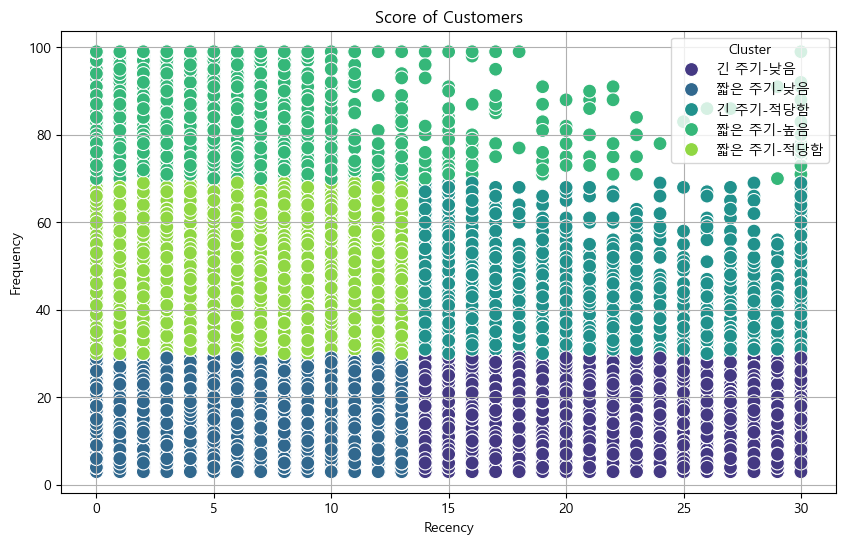

In [201]:
# 한글 폰트 설정 (Windows 기준)
plt.rcParams['font.family'] = 'Malgun Gothic'  # Windows에서는 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False     # 마이너스 기호 깨짐 방지

plt.figure(figsize=(10, 6))
sns.scatterplot(data=rfr_df, x='recency', y='frequency', hue='Customer_Segment', palette='viridis', s=100)
plt.title('Score of Customers')
plt.xlabel('Recency')
plt.ylabel('Frequency')
plt.legend(title='Cluster')
plt.grid()
plt.show()

In [215]:
rfr_df['Customer_Segment'].value_counts()

Customer_Segment
긴 주기-낮음      101161
짧은 주기-낮음      75865
짧은 주기-적당함     20462
긴 주기-적당함       4486
짧은 주기-높음       4235
Name: count, dtype: int64

In [211]:
abc = rfr_df.groupby('Customer_Segment')['user_id'].count().reset_index()

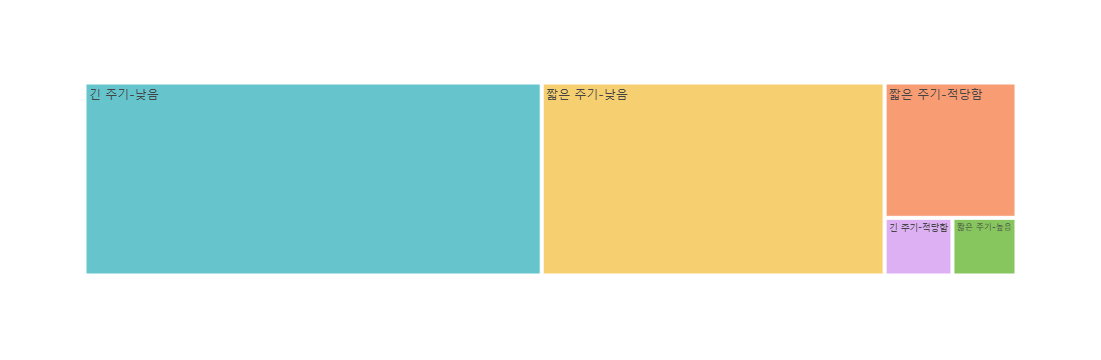

In [213]:
import plotly.express as px

fig = px.treemap(data_frame=abc, path=['Customer_Segment'], values='user_id', color_discrete_sequence=px.colors.qualitative.Pastel)
fig.show()

### 문제 발생
- 상관성 분석 -> RF는 고객 기준으로 뽑아낸 값이지만 모든 데이터는 기준이 없음. 
- 그럼 이 문제를 전체 데이터를 고객 기준으로 변경하고 해당 데이터에서는 가장 최신 데이터만 가져오는 것으로 기준을 하고 RF와 기준을 정한 데이터를 merge후 상관성 확인 하는 것이 맞나?

In [249]:
# 각 user_id별로 최대 order_number 계산
max_order_numbers = df.groupby('user_id')['order_number'].max().reset_index()

# max_order_numbers와 df를 병합하여 최대 order_number에 해당하는 행만 보기
df_max_order = pd.merge(df, max_order_numbers, on=['user_id', 'order_number'], how='inner')

In [235]:
result = pd.merge(df_max_order, rfr_df, on='user_id', how='inner')

In [241]:
result = result[result['days_since_prior_order'].isna() == False]

In [255]:
from scipy.stats import pointbiserialr
correlation_list = []
def pointbiserialr_calc_2(reordered, column):
    correlation, p_value = pointbiserialr(result[reordered], result[column])

    print(f"{column}과 {reordered}의 포인트 바이세리얼 상관계수: {round(correlation, 6)}")
    print("p-value:", p_value)
    correlation_list.append(round(correlation, 6))

In [257]:
for i in columns:
    pointbiserialr_calc_2('reordered_x', i)
    print()

order_number과 reordered_x의 포인트 바이세리얼 상관계수: 0.236499
p-value: 0.0

order_dow과 reordered_x의 포인트 바이세리얼 상관계수: -0.010267
p-value: 5.499891863176833e-51

order_hour_of_day과 reordered_x의 포인트 바이세리얼 상관계수: -0.017195
p-value: 1.2473201639627567e-139

days_since_prior_order과 reordered_x의 포인트 바이세리얼 상관계수: -0.146145
p-value: 0.0

product_id과 reordered_x의 포인트 바이세리얼 상관계수: 0.004926
p-value: 5.767220700596737e-13

add_to_cart_order과 reordered_x의 포인트 바이세리얼 상관계수: -0.149618
p-value: 0.0

recency과 reordered_x의 포인트 바이세리얼 상관계수: -0.146145
p-value: 0.0

frequency과 reordered_x의 포인트 바이세리얼 상관계수: 0.236499
p-value: 0.0



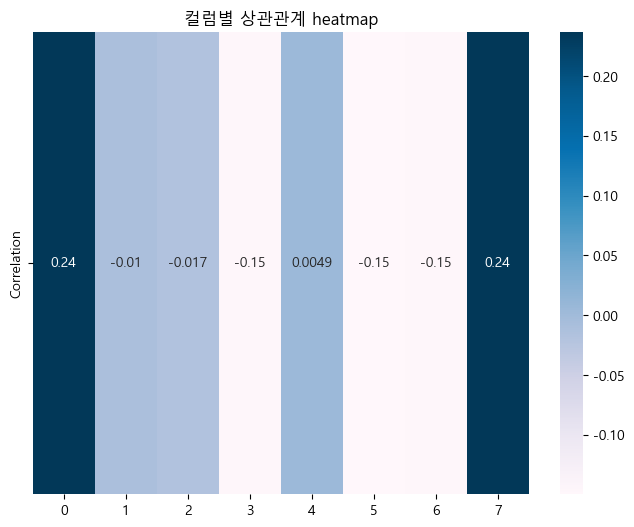

In [267]:
plt.rcParams['font.family'] = 'Malgun Gothic'  # Windows에서는 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False     # 마이너스 기호 깨짐 방지

data = {
    'variable' : columns,
    'Correlation' : correlation_list
}

corr = pd.DataFrame(data)

plt.figure(figsize=(8, 6))
sns.heatmap(corr[['Correlation']].T, annot=True, cmap='PuBu')
plt.title('컬럼별 상관관계 heatmap')
plt.show()